In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# import talib  # For technical analysis indicators
from ta import trend, momentum, volume, volatility, others

# import MetaTrader5 as mt5
import pytz
from datetime import datetime

In [2]:
def validating_bar(prices, hh, hl, ll, lh):
    if len(prices) < 1:
        if prices["Open"].iloc[-1] < prices["Close"].iloc[-1]:
            lh = prices[
                prices["Open"] and prices["Close"] and prices["High"] and prices["Low"]
            ].iloc[-1]
        else:
            hl = prices[
                prices["Open"] and prices["Close"] and prices["High"] and prices["Low"]
            ].iloc[-1]
        return hh, hl, ll, lh

    current_price = prices[
        prices["Open"] and prices["Close"] and prices["High"] and prices["Low"]
    ].iloc[-1]

    # Check price going up or down
    if current_price["Open"] > current_price["Close"]:
        print()
        #
    else:
        #
        print()

In [3]:
def check_high_low_(prices):
    # checks highs and lows within 21 ema

    # gets ema21
    ema21 = trend.ema_indicator(prices["Close"], window=21)

    if ema21 > prices["High"].iloc[-1] and ema21 < prices["Low"].iloc[-1]:
        # cross above ema21
        return True
    else:
        return False

In [4]:
def detect_trendline_breaks(prices, window=5):
    # Check if we have enough data
    if len(prices) < window:
        return "No Break"

    # Calculate linear regression for the trendline
    x = np.arange(window)
    y = prices["Close"].iloc[-window:].values  # Get the last 'window' closing prices

    # Fit a linear regression line to the last 'window' prices
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate the trendline values
    trendline = slope * x + intercept

    # Check for break above or below the trendline
    last_price = prices["Close"].iloc[-1]

    if last_price > trendline[-1]:  # Break above trendline
        return "Break Above"
    elif last_price < trendline[-1]:  # Break below trendline
        return "Break Below"

    return "No Break"

In [5]:
def avoid_counter_trend(prices, current_trend):
    if current_trend == "Uptrend":
        if (
            prices["Close"].iloc[-1] < prices["Close"].iloc[-2]
        ):  # Last close is lower than previous
            return True  # Avoid counter-trend trade
    elif current_trend == "Downtrend":
        if (
            prices["Close"].iloc[-1] > prices["Close"].iloc[-2]
        ):  # Last close is higher than previous
            return True  # Avoid counter-trend trade

    return False  # No counter-trend trade to avoid


In [6]:
def high_probability_setups(prices):
    # ema21 = talib.EMA(prices['Close'], timeperiod=21)
    ema21 = trend.ema_indicator(prices["Close"], window=21)

    if (prices["Close"].iloc[-1] < ema21.iloc[-1]) and (
        prices["Close"].iloc[-2] > ema21.iloc[-2]
    ):
        return "Entry Short"  # Price crosses below EMA

    if (prices["Close"].iloc[-1] > ema21.iloc[-1]) and (
        prices["Close"].iloc[-2] < ema21.iloc[-2]
    ):
        return "Entry Long"  # Price crosses above EMA

    return "No Setup"


In [7]:
def break_high_low(
    prices: pd.DataFrame, up: pd.Series | None, down: pd.Series | None, state
):
    if state == 1:
        if up is None:
            up = prices.iloc[-1]
        elif prices["Close"].iloc[-1] > up["Close"] or prices["Open"].iloc[-1] > prices["Close"].iloc[-1]:
            up = prices.iloc[-1]

        elif prices["Close"].iloc[-1] < up["Low"]:
            down = prices.iloc[-1]
            state = 2

        return up, down, state
    elif state == 2:
        if prices["Close"].iloc[-1] < down["Close"] or prices["Open"].iloc[-1]< prices["Close"].iloc[-1]:
            down = prices.iloc[-1]

        elif prices["Close"].iloc[-1] < up["High"]:
            up = prices.iloc[-1]
            state = 3
        return up, down, state
    elif state == -1:
        if down is None:
            down = prices.iloc[-1]
        elif prices["Close"].iloc[-1] < down["Close"] or prices["Open"].iloc[-1]< prices["Close"].iloc[-1]:
            down = prices.iloc[-1]
        elif prices["Close"].iloc[-1] > down["High"]:
            up = prices.iloc[-1]
            state = -2
        return up, down, state
    elif state == -2:
        if prices["Close"].iloc[-1] > up["Close"] or prices["Open"].iloc[-1] > prices["Close"].iloc[-1]:
            up = prices.iloc[-1]

        elif prices["Close"].iloc[-1] < up["Low"]:
            up = prices.iloc[-1]
            state = -3
        return up, down, state
    else:
        return up, down, state


In [8]:
def validate_signal_bar(prices):
    # Check if there are at least 2 rows
    if len(prices) < 2:
        return "No Signal"  # Not enough data for signal bar validation

    last_close = prices["Close"].iloc[-1]
    second_last_close = prices["Close"].iloc[-2]

    if last_close > second_last_close:  # Bullish signal bar
        return "Bullish Signal"
    elif last_close < second_last_close:  # Bearish signal bar
        return "Bearish Signal"
    return "No Signal"

In [9]:
def trading_algorithm(price_data: pd.DataFrame):
    signals = []
    state = 0
    up = None
    low = None

    for index in tqdm(range(len(price_data))):
        price_data_slice = price_data.iloc[: index + 1]  # Get data up to current index

        setup_signal = high_probability_setups(price_data_slice)
        if setup_signal == "No Setup":
            state = 0
            up = None
            low = None
        elif setup_signal == "Entry Long":
            if state == 0:
                state = 1
        elif setup_signal == "Entry Short":
            if state == 0:
                state = -1
        if state != 0:
            up, low, state = break_high_low(
                price_data_slice, up=up, down=low, state=state
            )
        print(state)

        if (
            state == 3 and setup_signal == "Entry Long"
            # and trading_range
        ):
            signals.append("Buy")

        elif (
            state == -3 and setup_signal == "Entry Short"
            # and trading_range
        ):
            signals.append("Sell")
        else:
            signals.append("Hold")
    return signals

In [10]:
def backtest(prices, signals, atr_multiplier=2, SLTPRatio=1):
    # Calculate ATR and assign signals
    prices["ATR"] = volatility.average_true_range(
        prices["High"], prices["Low"], prices["Close"], window=14
    )
    prices["signal"] = signals

    # Precompute stop-loss and take-profit levels
    prices["stop_loss"] = np.where(
        prices["signal"] == "Buy",
        prices["Close"] - (atr_multiplier * prices["ATR"]),
        prices["Close"] + (atr_multiplier * prices["ATR"]),
    )
    prices["take_profit"] = np.where(
        prices["signal"] == "Buy",
        prices["Close"] + (atr_multiplier * SLTPRatio * prices["ATR"]),
        prices["Close"] - (atr_multiplier * SLTPRatio * prices["ATR"]),
    )

    # Initialize columns for results
    prices["entry_price"] = np.where(prices["signal"].notna(), prices["Close"], np.nan)
    prices["exit_price"] = np.nan
    prices["PnL"] = np.nan

    # Track stop-loss and take-profit breaches
    for index, row in prices.iterrows():
        if row["signal"] == "Buy":
            # Find first row where low breaches stop_loss or high breaches take_profit
            breached_stop_loss = (prices.loc[index:, "Low"] < row["stop_loss"]).idxmax()
            breached_take_profit = (
                prices.loc[index:, "High"] > row["take_profit"]
            ).idxmax()

            if breached_stop_loss < breached_take_profit:
                exit_price = row["stop_loss"]
            else:
                exit_price = row["take_profit"]

            # Assign exit price and PnL
            prices.loc[index, "exit_price"] = exit_price
            prices.loc[index, "PnL"] = (exit_price - row["entry_price"]) / row[
                "entry_price"
            ]

        elif row["signal"] == "Sell":
            # Find first row where high breaches stop_loss or low breaches take_profit
            breached_stop_loss = (
                prices.loc[index:, "High"] > row["stop_loss"]
            ).idxmax()
            breached_take_profit = (
                prices.loc[index:, "Low"] < row["take_profit"]
            ).idxmax()

            if breached_stop_loss < breached_take_profit:
                exit_price = row["stop_loss"]
            else:
                exit_price = row["take_profit"]

            # Assign exit price and PnL
            prices.loc[index, "exit_price"] = exit_price
            prices.loc[index, "PnL"] = (row["entry_price"] - exit_price) / row[
                "entry_price"
            ]

    return prices


In [11]:
def plot_signals(price_data, signals):
    plt.figure(figsize=(12, 6))
    plt.plot(price_data["Close"], label="Price", color="blue")

    buy_signals = [
        price_data["Close"][i] if signal == "Buy" else np.nan
        for i, signal in enumerate(signals)
    ]
    sell_signals = [
        price_data["Close"][i] if signal == "Sell" else np.nan
        for i, signal in enumerate(signals)
    ]

    plt.plot(buy_signals, marker="^", linestyle="", color="green", label="Buy Signal")
    plt.plot(sell_signals, marker="v", linestyle="", color="red", label="Sell Signal")

    plt.title("Trading Signals")
    plt.legend()
    plt.show()


In [12]:
df = pd.read_csv("Q1-24M5.csv")
df[["Open", "High", "Low", "Close"]]

,Open,High,Low,Close
0,2063.21,2065.44,2063.12,2065.30
1,2065.32,2065.32,2064.11,2064.64
2,2064.60,2066.45,2064.45,2065.77
3,2065.68,2066.18,2065.09,2065.63
4,2065.64,2065.86,2065.35,2065.60
...,...,...,...,...
17310,2221.28,2222.21,2221.16,2221.87
17311,2222.03,2223.53,2222.02,2223.40
17312,2223.35,2236.11,2223.20,2229.42
17313,2229.37,2233.02,2226.05,2232.71


  2%|██▊                                                                                                                     | 402/17315 [00:00<00:08, 1987.85it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
1
0
0
0
-1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
-1
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
1
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
-1
0
0
0
1
0
0
-1
-1
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
1
1
1
1
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0


  5%|█████▉                                                                                                                  | 851/17315 [00:00<00:07, 2085.66it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
1
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
-1
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
-1
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
1
1
1
1
0
0
-1
-1
0
0
0
0
0
0
0
0
0


  8%|█████████▏                                                                                                             | 1341/17315 [00:00<00:07, 2194.19it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
-1
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
1
0
0
0
1
1
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 11%|████████████▌                                                                                                          | 1819/17315 [00:00<00:06, 2240.65it/s]

0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
1
0
0
-1
-1
-1
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
-1
0
1
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
-1
-1
0
-1
-1
0
0
-1
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
-1
0
0
1
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
-1
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
0
-1


 12%|██████████████                                                                                                         | 2044/17315 [00:00<00:07, 2156.66it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
-1
-1
0
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0


 14%|█████████████████▏                                                                                                     | 2497/17315 [00:01<00:06, 2205.74it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
1
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
1
1
0


 17%|████████████████████▍                                                                                                  | 2982/17315 [00:01<00:06, 2205.08it/s]

0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
-1
0
0
1
1
1
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
-1
-1
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
1
1
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0


 20%|███████████████████████▌                                                                                               | 3428/17315 [00:01<00:06, 2115.10it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
0
0
0
-1
0
0
1
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
1
0
0
0
-1
-1
-1
0
1
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
-1
-1
-1
0
1
0
0
0
0
0
0
-1
0
0
0
1
0
0


 23%|██████████████████████████▊                                                                                            | 3907/17315 [00:01<00:05, 2248.14it/s]

0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
-1
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
-1
-1
0
-1
-1
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
-1
-1
-1
-1
0
0
-1
0
0
1
0
0
0
-1
-1
-1
0
0
0
0
1
1
1
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
1
0
0
1
1
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1

 25%|█████████████████████████████▉                                                                                         | 4365/17315 [00:02<00:05, 2232.29it/s]

-1
0
0
0
0
0
0
0
1
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
1
0
-1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
-1
-1
-1
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0


 28%|█████████████████████████████████                                                                                      | 4806/17315 [00:02<00:05, 2126.96it/s]

0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
0
-1
0
0
1
0
-1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
-1
-1
0
-1
0
1
0
-1
-1
0
-1
0
0
0
0
0
0
1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 30%|███████████████████████████████████▉                                                                                   | 5236/17315 [00:02<00:05, 2064.86it/s]

0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
0
0
-1
0
0
0
0
0
1
1
0
0
0
1
0
-1
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
1
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 33%|██████████████████████████████████████▉                                                                                | 5663/17315 [00:02<00:05, 2046.70it/s]

0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
-1
-1
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0


 35%|█████████████████████████████████████████▋                                                                             | 6066/17315 [00:02<00:05, 1958.35it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
0
0
-1
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
-1
-1
0
-1
-1
-1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0


 38%|████████████████████████████████████████████▋                                                                          | 6506/17315 [00:03<00:05, 2072.42it/s]

0
0
0
0
0
0
0
0
1
0
-1
0
1
1
1
1
1
1
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
0
0
-1
0
1
1
0
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
1
1
0
1
1
0
1
0
0
-1
-1
0
0
-1
0
0
0
1
0
-1
-1
-1
0
1
0
-1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
-1
0
-1
-1
-1
-1
-1
0
0
0
0
0
1
0
0
0
0
0
0
0


 40%|███████████████████████████████████████████████▌                                                                       | 6919/17315 [00:03<00:05, 2016.14it/s]

0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
-1
0
1
1
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0


 41%|████████████████████████████████████████████████▉                                                                      | 7122/17315 [00:03<00:05, 1966.42it/s]

0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
1
1
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
-1
0
0
0
1
0
0
0
-1
-1
-1
-1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
1
1
0
0
1
1
0
0
0
1
1
0
0
0
1
0
-1
-1
-1
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
1
1
0
0
0


 43%|███████████████████████████████████████████████████▋                                                                   | 7528/17315 [00:03<00:05, 1708.70it/s]

0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
1
1
1
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
1
1
1
0
0
1
0
-1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
1
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
-1
-1
-1
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0


 47%|████████████████████████████████████████████████████████▎                                                              | 8185/17315 [00:03<00:04, 1968.36it/s]

0
0
0
0
0
0
0
0
0
-1
-1
-1
0
1
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
1
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
-1
-1
-1
-1
0
0
-1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0


 50%|███████████████████████████████████████████████████████████                                                            | 8595/17315 [00:04<00:04, 1984.02it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
0
0
1
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
-1
0
0
1
0
0
0
0
0
-1
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
-1
0
0
1
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
-1
0
0


 52%|█████████████████████████████████████████████████████████████▊                                                         | 8996/17315 [00:04<00:04, 1966.39it/s]

0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
-1
-1
0
0
-1
-1
-1
0
0
0
0
0
0
0
1
0
0
-1
-1
-1
-1
0
-1
0
0
0
0
1
1
0
1
1
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
0
1
0
-1
0
0
0
0
0
0
0
0
0
1
0
-1
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
0
0
0
0
0
0
-1
-1
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0


 53%|███████████████████████████████████████████████████████████████▏                                                       | 9194/17315 [00:04<00:04, 1895.27it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
1
1
1
1
1
0
-1
-1
0
0
-1
0
0
0
1
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
1
0
0
0
-1
0
1
1
0
0
0
0
0
1
1
1
1
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
-1
-1
-1
0
0
-1
-1
0
0
-1
0
0
1
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 55%|█████████████████████████████████████████████████████████████████▊                                                     | 9575/17315 [00:04<00:04, 1833.95it/s]

0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 57%|████████████████████████████████████████████████████████████████████▍                                                  | 9955/17315 [00:04<00:04, 1828.46it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
-1
0
1
0
0
0
-1
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0


 61%|███████████████████████████████████████████████████████████████████████▌                                              | 10503/17315 [00:05<00:03, 1793.78it/s]

0
-1
-1
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
-1
-1
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 10881/17315 [00:05<00:03, 1833.97it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
1
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
0
1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0


 64%|███████████████████████████████████████████████████████████████████████████▍                                          | 11065/17315 [00:05<00:03, 1793.94it/s]

0
0
0
0
0
0
0
0
0
0
1
1
1
0
-1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
-1
-1
-1
-1
0
0
0
0
-1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0


 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 11422/17315 [00:05<00:03, 1692.20it/s]

-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
-1
0
0
1
1
1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
1
1
0
1
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
-1
0
1
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 11761/17315 [00:05<00:03, 1599.35it/s]

0
0
-1
-1
0
0
0
-1
-1
-1
0
0
0
0
0
1
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
-1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
1
1
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 12121/17315 [00:06<00:03, 1693.15it/s]

0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
0
1
0
-1
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 72%|█████████████████████████████████████████████████████████████████████████████████████                                 | 12473/17315 [00:06<00:02, 1673.85it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
-1
-1
-1
0
0
0
0
0
1
1
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
-1
-1
-1
-1
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
1
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0


 74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 12808/17315 [00:06<00:02, 1566.33it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
1
1
1
1
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
0
0
-1
0
0
1
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
0
0


 75%|████████████████████████████████████████████████████████████████████████████████████████▎                             | 12966/17315 [00:06<00:03, 1372.44it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
-1
0
1
0
-1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
1
0


 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                            | 13108/17315 [00:06<00:03, 1121.72it/s]

0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
1
0
-1
-1
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                          | 13434/17315 [00:07<00:03, 1184.16it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
-1
0
0
1
1
1
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
1
0
0
0
-1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
1
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                       | 13814/17315 [00:07<00:02, 1419.47it/s]

-1
-1
0
0
-1
0
1
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
-1
0
0
-1
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
1
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
-1
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
1
0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                      | 13964/17315 [00:07<00:02, 1380.97it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
1
1
1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
-1
0
0
0
0
1
0
-1
0
0
0
0
0
0
0
1
0
0
0
0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 14308/17315 [00:07<00:02, 1389.64it/s]

0
-1
-1
0
0
0
-1
0
1
0
0
0
0
-1
0
1
1
0
0
0
1
0
-1
-1
0
0
0
-1
-1
0
-1
-1
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
-1
0
-1
-1
0
-1
0
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
-1
0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
-1
0
0
1
0
0
0
-1
0
1
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 14705/17315 [00:08<00:01, 1611.49it/s]

0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
-1
-1
0
-1
0
1
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
-1
-1
0
-1
-1
0
0
-1
0
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 15072/17315 [00:08<00:01, 1692.07it/s]

0
0
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
-1
0
0
0
1
0
0
-1
-1
-1
-1
0
-1
-1
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
0
0
0
0
0
0
-1
-1
-1
0
1
0
0
0
-1
0
0
1
1
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
-1
0
1
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
-1
0
1
0
-1
-1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 15453/17315 [00:08<00:01, 1689.80it/s]

1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
0
-1
-1
-1
0
1
0
0
0
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15808/17315 [00:08<00:00, 1714.85it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
0
0
0
0
1
0
-1
0
0
0
0
0
1
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
-1
-1
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
1
0
1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0
-1
-1
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
1
0
-1
-1
0
0
-1
-1
-1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
1


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 16162/17315 [00:08<00:00, 1738.22it/s]

0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
1
1
0
1
1
1
1
1
1
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0
0
1
0
-1
0
1
0
0
0
-1
0
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
0
-1
-1
-1
-1
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
-1
-1
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
0
0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 16526/17315 [00:09<00:00, 1719.83it/s]

0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
-1
0
0
1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
-1
0
0
0
-1
-1
-1
0
0
0
0
1
1
0
0
0
0
1
0
0
0
-1
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
-1
-1
0
0
-1
0
1
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
-1
-1
0
0
0
1
1
0
0
0
0
1
0
-1
-1
-1
0
0
0
0
0
1
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
-1
0
0
0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 16699/17315 [00:09<00:00, 1543.63it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
-1
0
1
0
-1
-1
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
1
0
0
0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 17024/17315 [00:09<00:00, 1356.21it/s]

-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
-1
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
-1
0
0
1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17315/17315 [00:09<00:00, 1789.38it/s]


0
0
1
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
1
0
0
0
0
0
-1
0
0
0
0
1
0
0
0
0
0
-1
0
0
1
0
0
0
0
0


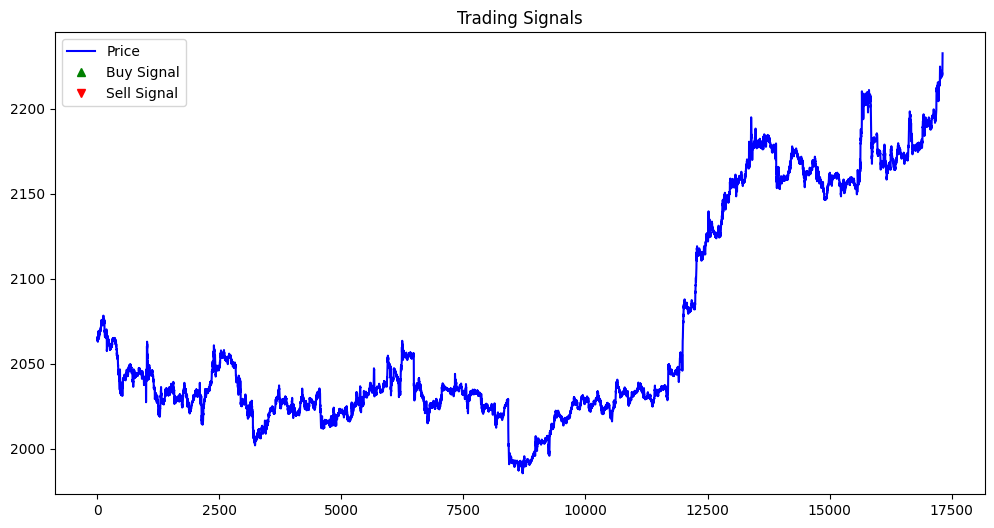

In [13]:
# close.head(5)
signals = trading_algorithm(df)  # access the 'close' column
plot_signals(df, signals)

In [14]:
df.head(5)

,time,Open,High,Low,Close,tick_volume,spread,real_volume
0,2024-01-02 01:00:00,2063.21,2065.44,2063.12,2065.30,183,21,0
1,2024-01-02 01:05:00,2065.32,2065.32,2064.11,2064.64,137,21,0
2,2024-01-02 01:10:00,2064.60,2066.45,2064.45,2065.77,154,19,0
3,2024-01-02 01:15:00,2065.68,2066.18,2065.09,2065.63,154,19,0
4,2024-01-02 01:20:00,2065.64,2065.86,2065.35,2065.60,167,19,0


In [16]:
backtest_result = backtest(df, signals, atr_multiplier=2, SLTPRatio=3)

In [17]:
def get_stats(data: pd.DataFrame):
    # Calculate trade statistics
    n_trades = data.count()[0]
    win_trades: pd.DataFrame = data[data["PnL"] > 0]
    loss_trades: pd.DataFrame = data[data["PnL"] < 0]

    try:
        win_rate = len(win_trades) / (len(win_trades) + len(loss_trades))
        loss_rate = len(loss_trades) / (len(win_trades) + len(loss_trades))
    except ZeroDivisionError:
        win_rate = 0
        loss_rate = 0
    avg_win = win_trades["PnL"].mean()
    avg_loss = loss_trades["PnL"].mean()
    avg_win = avg_win if not np.isnan(avg_win) else 0
    avg_loss = avg_loss if not np.isnan(avg_loss) else 0
    expectancy = (win_rate * avg_win) + (loss_rate * avg_loss)

    return n_trades, win_rate, loss_rate, avg_win, avg_loss, expectancy

In [18]:
complete_trades = backtest_result[~backtest_result["PnL"].isna()]

stats = pd.DataFrame(
    index=["n_trades", "win_rate", "loss_rate", "avg_win", "avg_loss", "expectancy"]
)

n_trades, win_rate, loss_rate, avg_win, avg_loss, expectancy = get_stats(
    complete_trades
)

stats["Complete Trades"] = [
    n_trades,
    win_rate,
    loss_rate,
    avg_win,
    avg_loss,
    expectancy,
]

stats

C:\Users\ervin\AppData\Local\Temp\ipykernel_14636\691811898.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_trades = data.count()[0]


,Complete Trades
n_trades,0
win_rate,0
loss_rate,0
avg_win,0
avg_loss,0
expectancy,0


In [26]:
import plotly.graph_objects as go
import pandas as pd

def plot_candlestick(data: pd.DataFrame):
    fig = go.Figure()
    fig.add_trace(
        go.Candlestick(
            x=data.index,
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
        )
    )
    # fig.add_trace(
    #     go.Scatter(
    #         x=data[data["PnL"] > 0].index,
    #         y=data[data["PnL"] > 0]["entry_price"],
    #         mode="markers",
    #         marker=dict(color="blue", size=10, symbol="triangle-up"),
    #         name="Win Trades",
    #     )
    # )
    # fig.add_trace(
    #     go.Scatter(
    #         x=data[data["PnL"] < 0].index,
    #         y=data[data["PnL"] < 0]["entry_price"],
    #         mode="markers",
    #         marker=dict(color="blue", size=10, symbol="triangle-down"),
    #         name="Lose Trades",
    #     )
    # )
    # fig.add_trace(
    #     go.Scatter(
    #         x=data.index,
    #         y=data["exit_price"],
    #         mode="markers",
    #         marker=dict(color="red", size=10, symbol="x"),
    #         name="Exit Price",
    #     )
    # )
    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data["EMA_21"],
            mode="lines",
            name="EMA_21",
        )
    )
    # fig.add_trace(
    #     go.Scatter(
    #         x=data.index,
    #         y=data["EMA_200"],
    #         mode="lines",
    #         name="EMA_200",
    #     )
    # )
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()


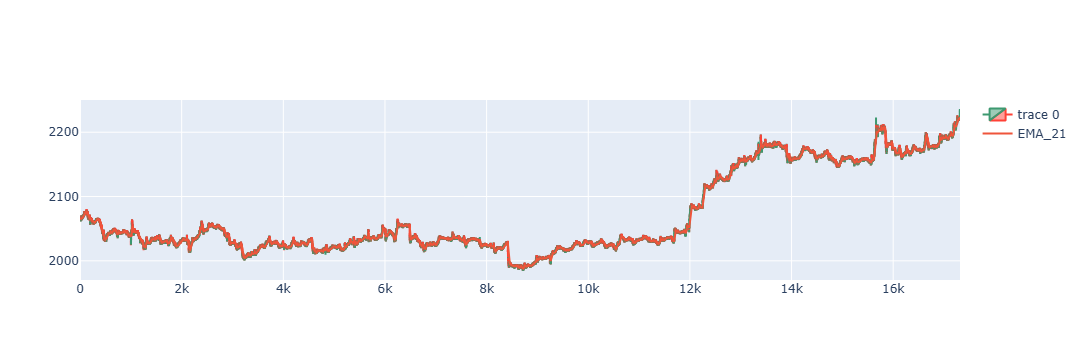

In [28]:
df["EMA_21"] = df["Close"].ewm(span=21, adjust=False).mean()
plot_candlestick(df)

In [24]:
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Candlestick(x=df["time"], open=df["open"], high=df["high"], low=df["low"], close=df["Close"], name="Price"))
fig.add_trace(go.Scatter(x=df["time"], y=df["Close"], mode="lines", name="Price"))
fig.add_trace(
    go.Scatter(
        x=complete_trades[
            (complete_trades["PnL"] > 0) & (complete_trades["signal"] == "Buy")
        ]["time"],
        y=complete_trades[
            (complete_trades["PnL"] > 0) & (complete_trades["signal"] == "Buy")
        ]["entry_price"],
        mode="markers",
        marker=dict(symbol="triangle-up", size=7, color="green"),
        name="Winning Buy Trades",
    )
)
fig.add_trace(
    go.Scatter(
        x=complete_trades[
            (complete_trades["PnL"] < 0) & (complete_trades["signal"] == "Buy")
        ]["time"],
        y=complete_trades[
            (complete_trades["PnL"] < 0) & (complete_trades["signal"] == "Buy")
        ]["entry_price"],
        mode="markers",
        marker=dict(symbol="triangle-up", size=7, color="red"),
        name="Losing Buy Trades",
    )
)
fig.add_trace(
    go.Scatter(
        x=complete_trades[
            (complete_trades["PnL"] > 0) & (complete_trades["signal"] == "Sell")
        ]["time"],
        y=complete_trades[
            (complete_trades["PnL"] > 0) & (complete_trades["signal"] == "Sell")
        ]["entry_price"],
        mode="markers",
        marker=dict(symbol="triangle-down", size=7, color="green"),
        name="Winning Sell Trades",
    )
)
fig.add_trace(
    go.Scatter(
        x=complete_trades[
            (complete_trades["PnL"] < 0) & (complete_trades["signal"] == "Sell")
        ]["time"],
        y=complete_trades[
            (complete_trades["PnL"] < 0) & (complete_trades["signal"] == "Sell")
        ]["entry_price"],
        mode="markers",
        marker=dict(symbol="triangle-down", size=7, color="red"),
        name="Losing Sell Trades",
    )
)
fig.update_layout(
    title="Backtest Results",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
)
fig.show()

NameError: name 'complete_trades' is not defined